In [1]:
from models.MNIST_Models import *
import torch
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import utils
from art.estimators.classification import PyTorchClassifier
from art.attacks.evasion import FastGradientMethod, BasicIterativeMethod, ProjectedGradientDescent, DeepFool
from art.defences.trainer import AdversarialTrainer
from copy import deepcopy
import os

In [2]:
# Load the data
BATCH_SIZE = 1024
EPS = 0.2

torch.manual_seed(42)
np.random.seed(42)
generator = torch.Generator().manual_seed(42)

# Define the transformation
train_transform = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomAffine(0, translate=(0.1, 0.1)), 
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,)),
])

test_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.1307,), (0.3081,)),
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=train_transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=test_transform, download=True)

# Split the training dataset into training and validation datasets
train_dataset, val_dataset = random_split(train_dataset, [50000, 10000], generator=generator)

# Create the dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

X_train, y_train = utils.loader_to_numpy(train_loader)
X_val, y_val = utils.loader_to_numpy(val_loader)
X_test, y_test = utils.loader_to_numpy(test_loader)

In [3]:
images, labels = next(iter(test_loader))

In [4]:
np.sum(labels.numpy() == y_test[:1024])

1024

In [5]:
def harden_model(clean_model, clean_classifier, BATCH_SIZE, EPS, model_name, attack_obj, plot_title):
    
    if attack_obj == FastGradientMethod:
        hardened_prefix = 'FGSM'
    elif attack_obj == BasicIterativeMethod:
        hardened_prefix = 'BIM'
    elif attack_obj == ProjectedGradientDescent:
        hardened_prefix = 'PGD'
    else:
        raise Exception("Enter a valid attack object")
        
    save_path = os.path.join('models', 'hardened_state', f'{hardened_prefix}_{model_name}.pth')
                             
    try:
        hardened_model = torch.load(save_path)
        hardened_classifier = PyTorchClassifier(
            model=hardened_model,
            loss=torch.nn.CrossEntropyLoss(),
            optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
            input_shape=(1, 28, 28),
            nb_classes=10,
            preprocessing=(0.1307, 0.3081),
            device_type='gpu'
        )
        attack = attack_obj(hardened_classifier, batch_size=BATCH_SIZE, eps=EPS)
    except:
        hardened_model = deepcopy(clean_model)
        hardened_classifier = PyTorchClassifier(
            model=hardened_model,
            loss=torch.nn.CrossEntropyLoss(),
            optimizer=torch.optim.Adam(hardened_model.parameters(), lr=0.01),
            input_shape=(1, 28, 28),
            nb_classes=10,
            preprocessing=(0.1307, 0.3081),
            device_type='gpu'
        )
        attack = attack_obj(hardened_classifier, batch_size=BATCH_SIZE, eps=EPS)
        adv_trainer = AdversarialTrainer(hardened_classifier, attacks=attack, ratio=0.5)
        adv_trainer.fit(X_train, y_train, batch_size=BATCH_SIZE, nb_epochs=10)
        torch.save(adv_trainer.classifier.model, save_path)
        hardened_classifier = adv_trainer.classifier
    
    eps_values = [0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
    utils.compare_classifiers(clean_classifier, hardened_classifier, X_test, y_test, eps_values, batch_size=BATCH_SIZE, title=plot_title)
    
    print('Hardened model accuracy on clean test data: ', np.sum(np.argmax(hardened_classifier.predict(X_test), axis=1) == y_test) / len(y_test))
    print(f'Hardened model accuracy on {attack.__class__.__name__} adversarial test data: ', utils.evaluate_attack(attack, hardened_classifier, X_test, y_test))

In [6]:
def run_adversarial_process(clean_model, BATCH_SIZE, EPS, model_name, plot_title):
    clean_classifier = PyTorchClassifier(
    model=clean_model,
    loss=torch.nn.CrossEntropyLoss(),
    optimizer=torch.optim.Adam(clean_model.parameters(), lr=0.01),
    input_shape=(1, 28, 28),
    nb_classes=10,
    preprocessing=(0.1307, 0.3081),
    device_type='gpu'
)

    # Get the clean accuracy
    print(f"Clean accuracy: {utils.test_model(clean_model, test_loader, device='cuda')}")
    
    # Try FGSM
    attack = FastGradientMethod(clean_classifier, batch_size=BATCH_SIZE, eps=EPS)
    print('Accuracy on FGSM adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
    utils.plot_images(X_test, y_test, clean_classifier, attack, 'Clean vs FGSM', n=5)
    
    # Try BIM
    attack = BasicIterativeMethod(clean_classifier, batch_size=BATCH_SIZE, eps=EPS)
    print('Accuracy on BIM adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
    utils.plot_images(X_test, y_test, clean_classifier, attack, 'Clean vs BIM', n=5)
    
    # Try PGD
    attack = ProjectedGradientDescent(clean_classifier, batch_size=BATCH_SIZE, eps=EPS)
    print('Accuracy on PGD adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
    utils.plot_images(X_test, y_test, clean_classifier, attack, 'Clean vs PGD', n=5)
    
    # Try deepfool
    attack = DeepFool(clean_classifier, batch_size=BATCH_SIZE)
    print('Accuracy on DeepFool adversarial test data: ', utils.evaluate_attack(attack, clean_classifier, X_test, y_test))
    utils.plot_images(X_test, y_test, clean_classifier, attack, 'Clean vs DeepFool', n=5)
    
    # harden with BIM
    harden_model(clean_model, clean_classifier, BATCH_SIZE, EPS, model_name, BasicIterativeMethod, plot_title + ' Hardened with BIM')
    
    # harden with PGD
    harden_model(clean_model, clean_classifier, BATCH_SIZE, EPS, model_name, ProjectedGradientDescent, plot_title + ' Hardened with PGD')
    
    # harden with FGSM
    harden_model(clean_model, clean_classifier, BATCH_SIZE, EPS, model_name, FastGradientMethod, plot_title + ' Hardened with FGSM')

    # Not hardening with DeepFool, requires too much time

Clean accuracy: 0.9884
Accuracy on FGSM adversarial test data:  0.5251


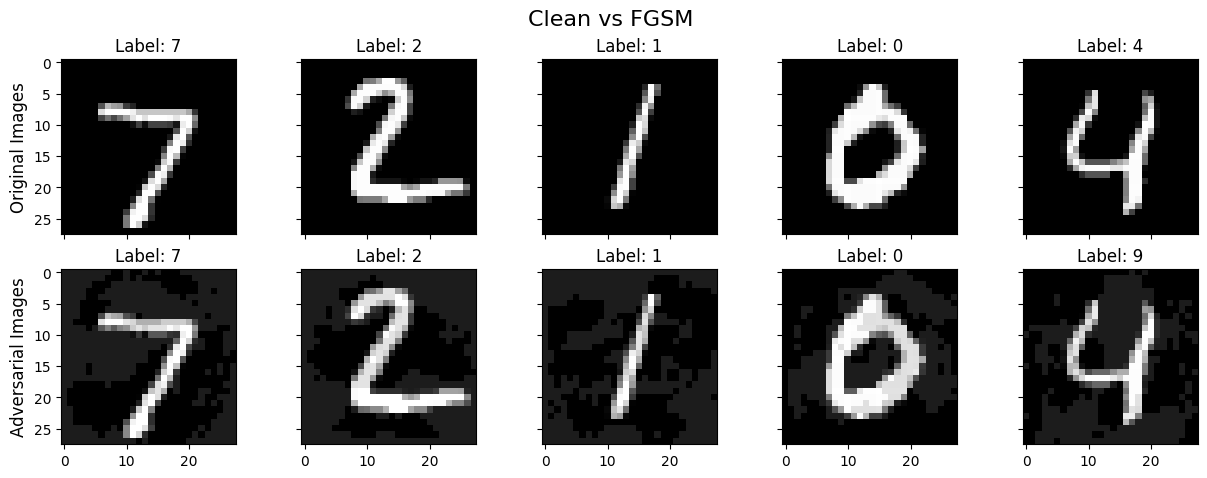

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on BIM adversarial test data:  0.1897


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

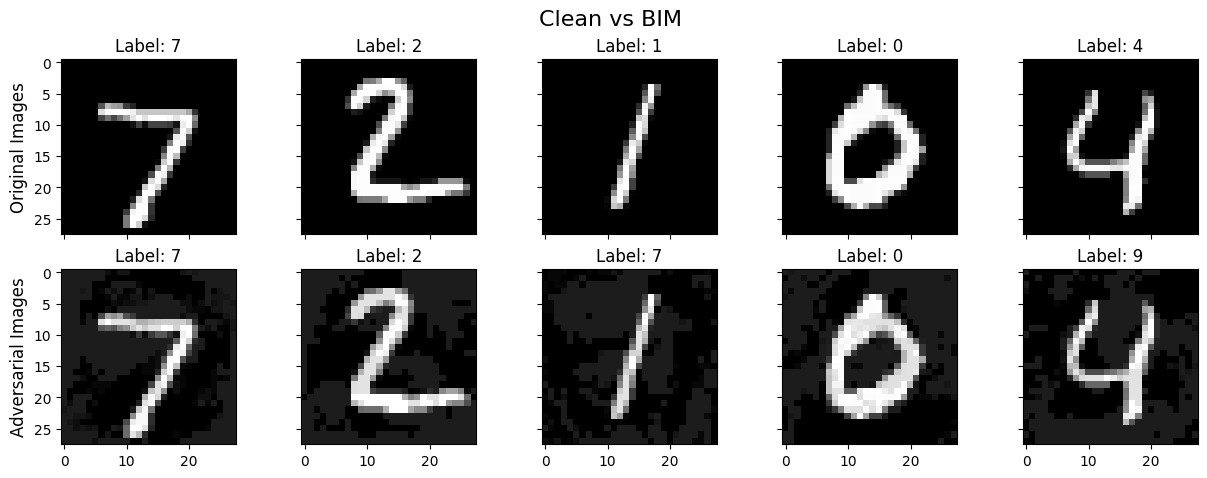

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on PGD adversarial test data:  0.1897


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

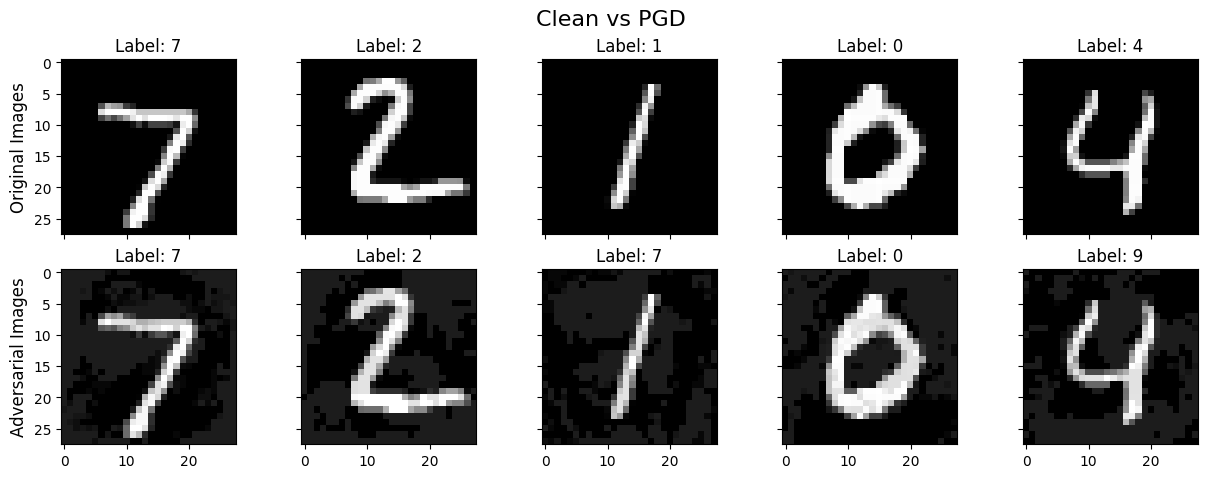

DeepFool:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on DeepFool adversarial test data:  0.0133


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

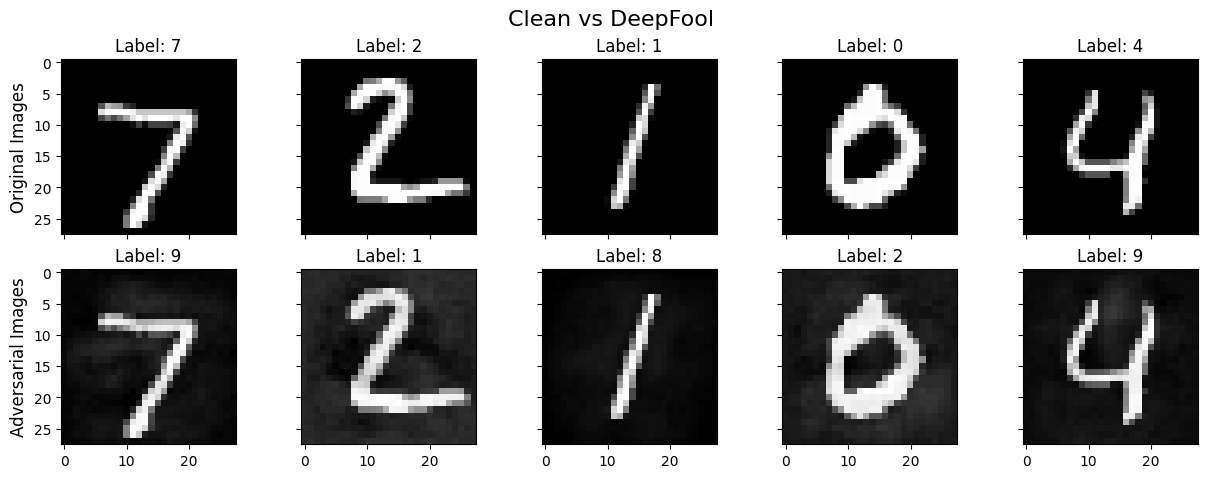

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

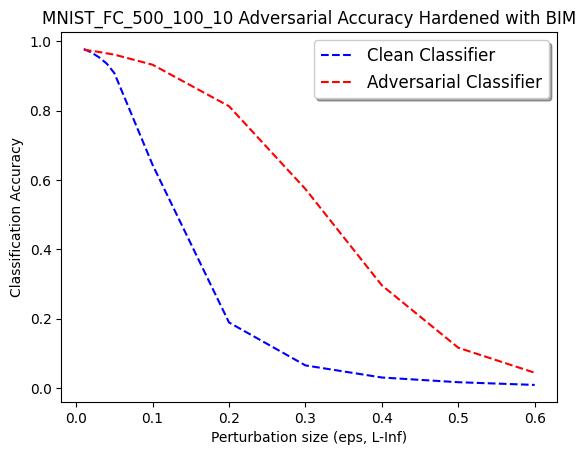

Hardened model accuracy on clean test data:  0.9778


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Hardened model accuracy on BasicIterativeMethod adversarial test data:  0.8168


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

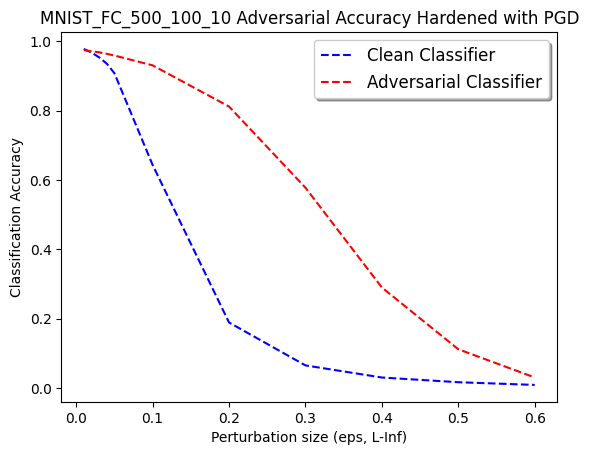

Hardened model accuracy on clean test data:  0.978


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Hardened model accuracy on ProjectedGradientDescent adversarial test data:  0.815


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

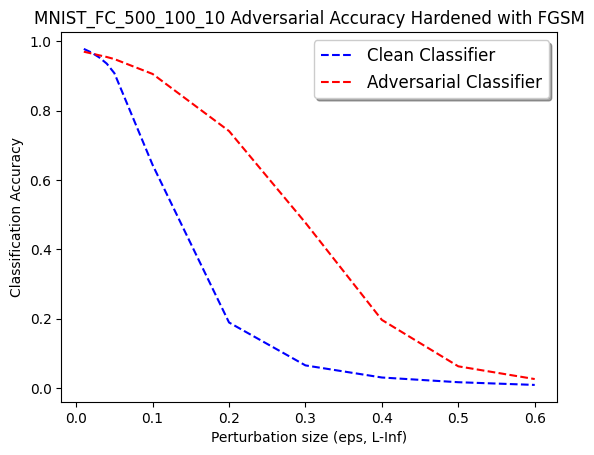

Hardened model accuracy on clean test data:  0.9736
Hardened model accuracy on FastGradientMethod adversarial test data:  0.8335


In [7]:
# load the FC model
clean_model = MNIST_FC_500_100_10()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_FC_500_100_10.pth'))
clean_model.eval()

run_adversarial_process(clean_model, BATCH_SIZE, EPS, 'MNIST_FC_500_100_10', 'MNIST_FC_500_100_10 Adversarial Accuracy')

Clean accuracy: 0.9951
Accuracy on FGSM adversarial test data:  0.7865


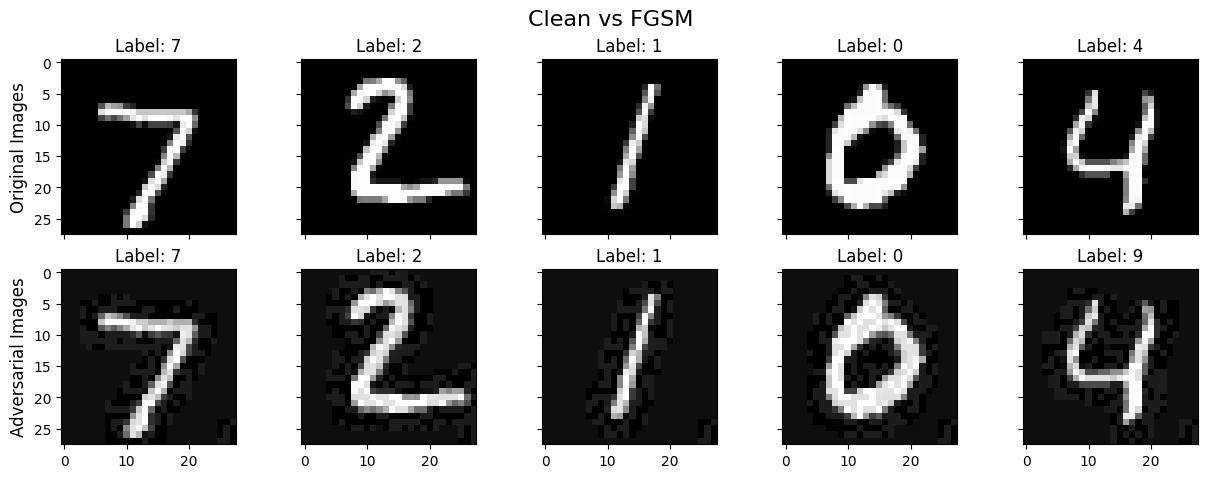

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on BIM adversarial test data:  0.2252


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

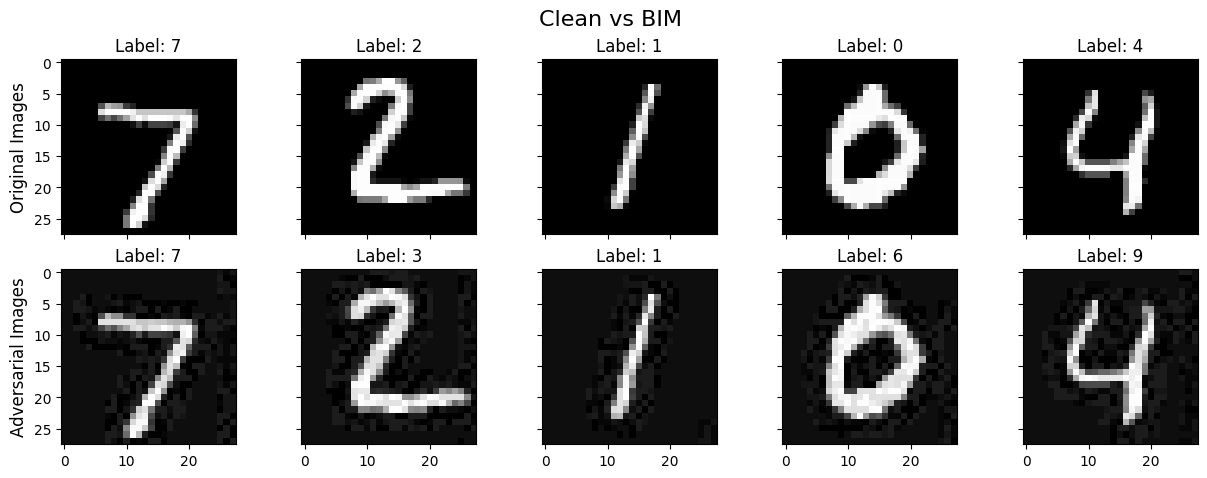

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on PGD adversarial test data:  0.2252


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

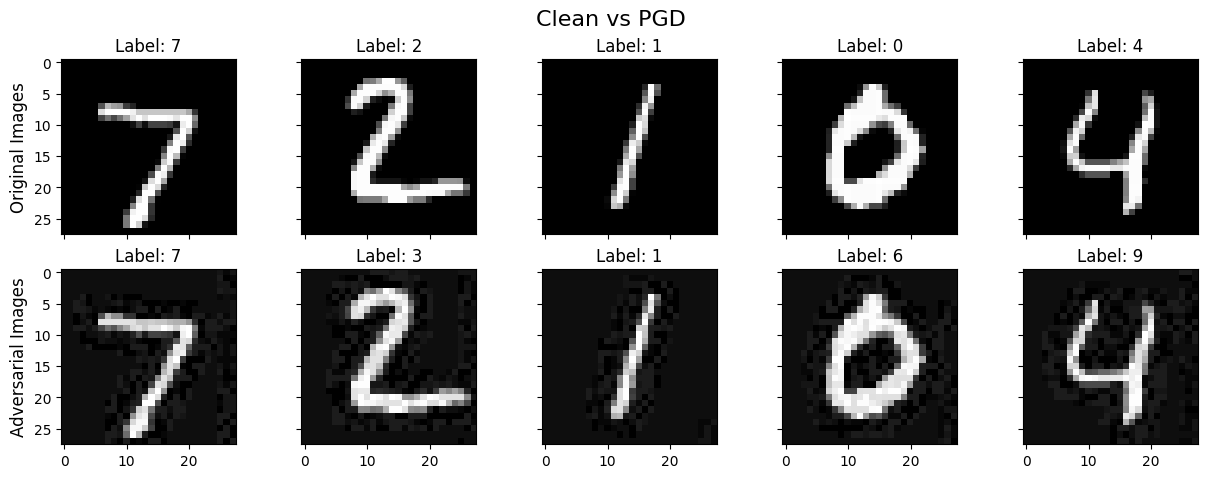

DeepFool:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on DeepFool adversarial test data:  0.0314


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

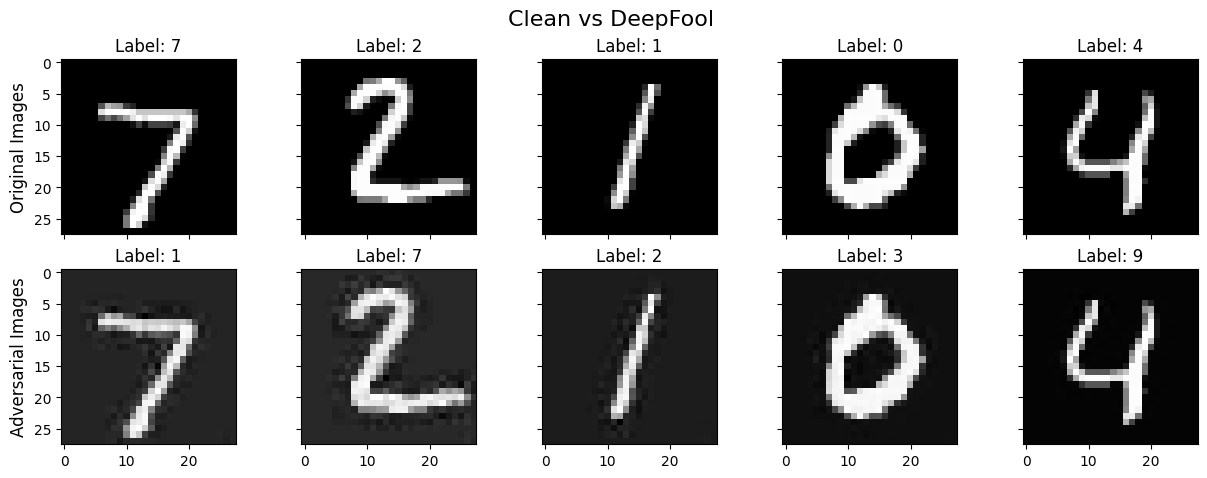

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

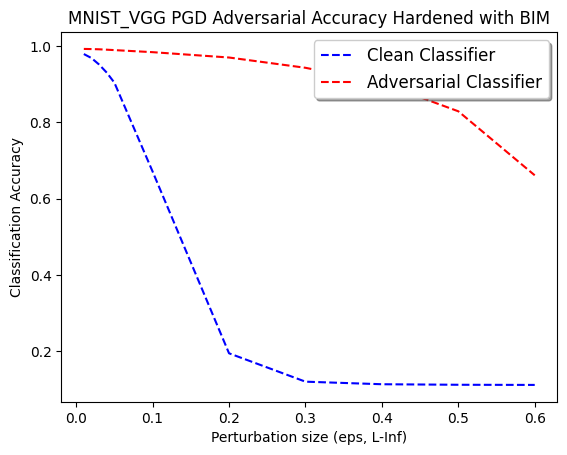

Hardened model accuracy on clean test data:  0.9925


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Hardened model accuracy on BasicIterativeMethod adversarial test data:  0.9703


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

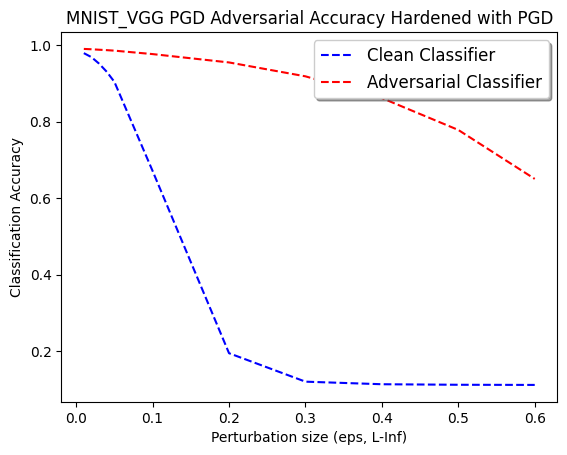

Hardened model accuracy on clean test data:  0.9906


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Hardened model accuracy on ProjectedGradientDescent adversarial test data:  0.9555


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

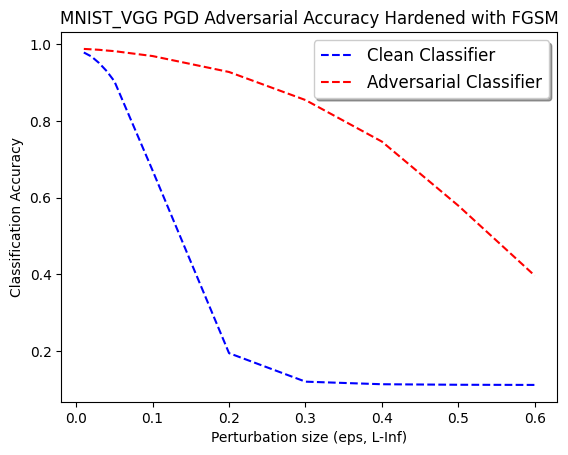

Hardened model accuracy on clean test data:  0.9898
Hardened model accuracy on FastGradientMethod adversarial test data:  0.9634


In [8]:
# load the VGG model
clean_model = MNIST_VGG()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_VGG.pth'))
clean_model.eval()

run_adversarial_process(clean_model, BATCH_SIZE, EPS, 'MNIST_VGG', 'MNIST_VGG PGD Adversarial Accuracy')

Clean accuracy: 0.9927
Accuracy on FGSM adversarial test data:  0.8184


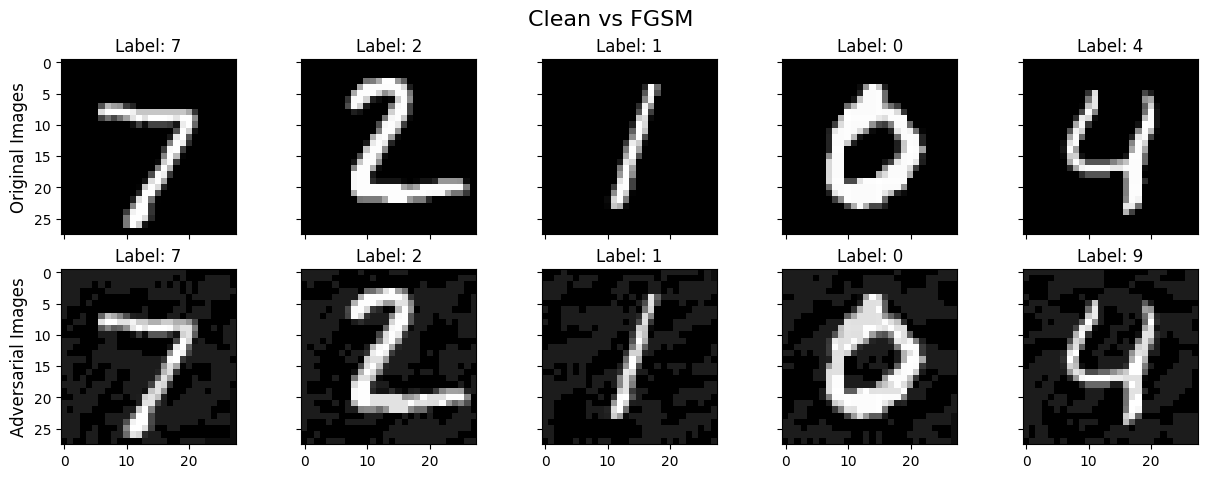

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on BIM adversarial test data:  0.3073


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

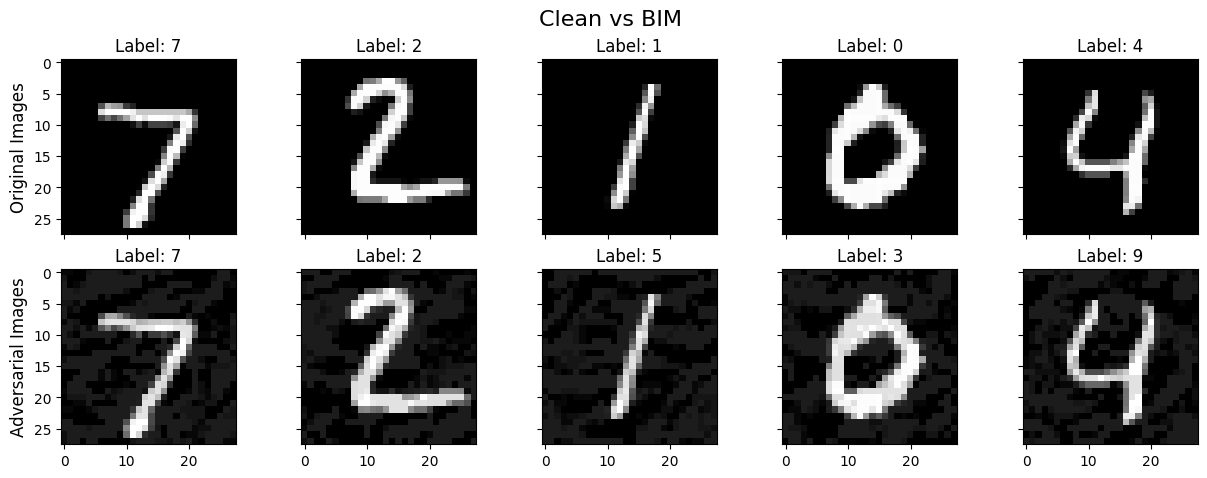

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on PGD adversarial test data:  0.3073


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

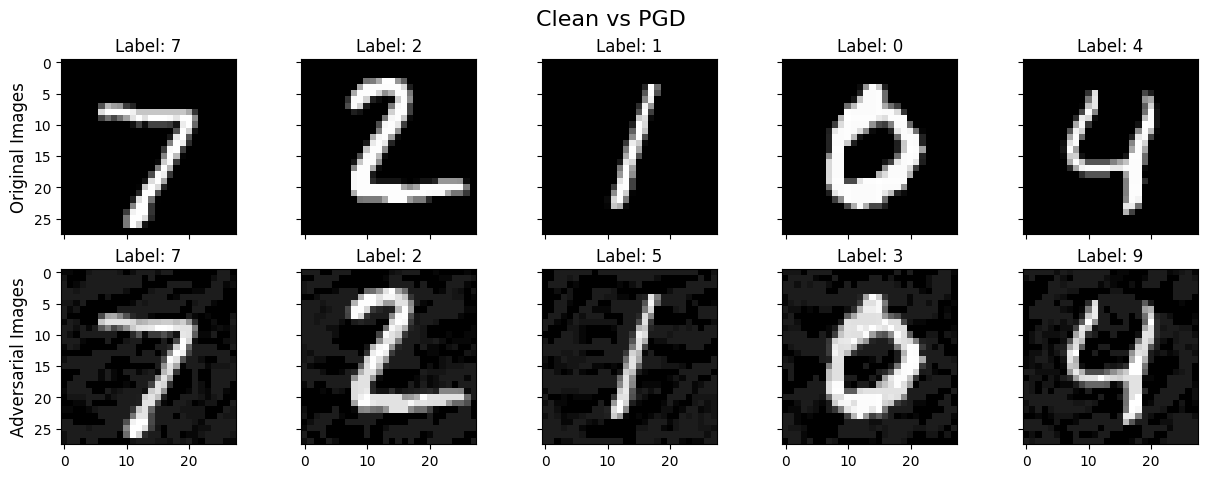

DeepFool:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on DeepFool adversarial test data:  0.0187


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

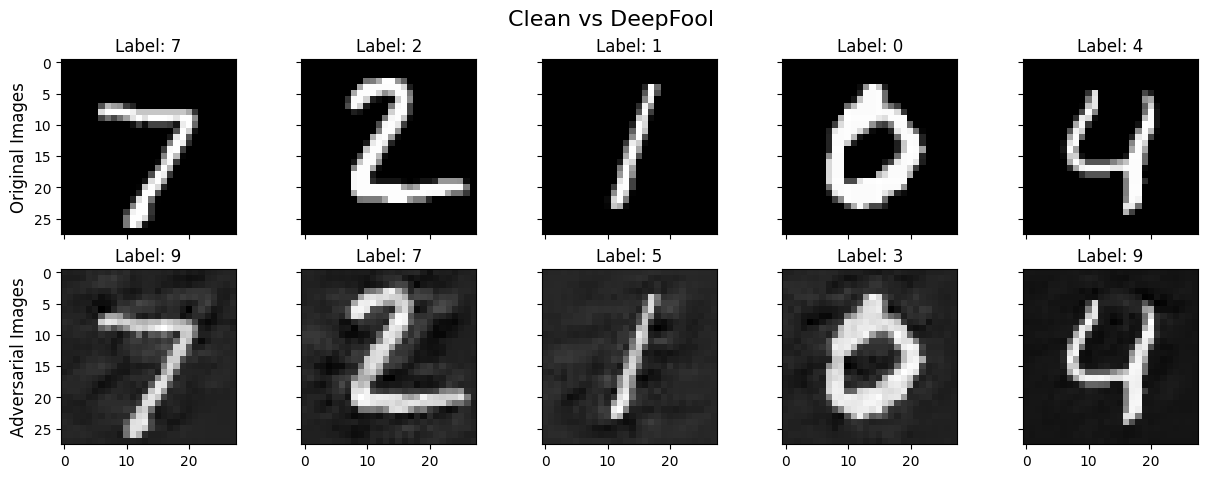

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

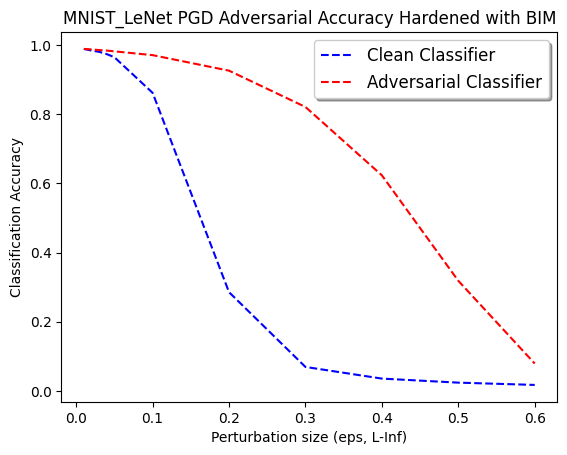

Hardened model accuracy on clean test data:  0.9898


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Hardened model accuracy on BasicIterativeMethod adversarial test data:  0.9282


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

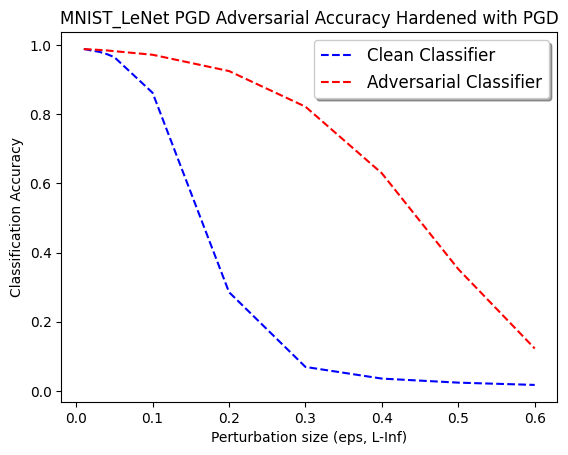

Hardened model accuracy on clean test data:  0.9895


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Hardened model accuracy on ProjectedGradientDescent adversarial test data:  0.927


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

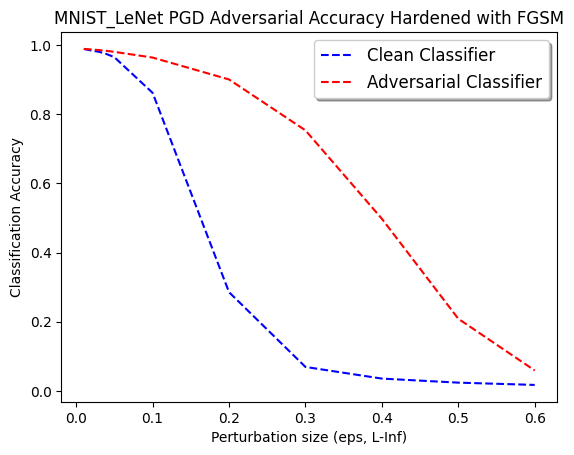

Hardened model accuracy on clean test data:  0.9903
Hardened model accuracy on FastGradientMethod adversarial test data:  0.94


In [9]:
# load the LeNet model
clean_model = MNIST_LeNet()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_LeNet.pth'))
clean_model.eval()

run_adversarial_process(clean_model, BATCH_SIZE, EPS, 'MNIST_LeNet', 'MNIST_LeNet PGD Adversarial Accuracy')

/home/pogrebitskiy.d/miniconda3/lib/python3.12/site-packages/torchvision/models/googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


Clean accuracy: 0.994
Accuracy on FGSM adversarial test data:  0.2954


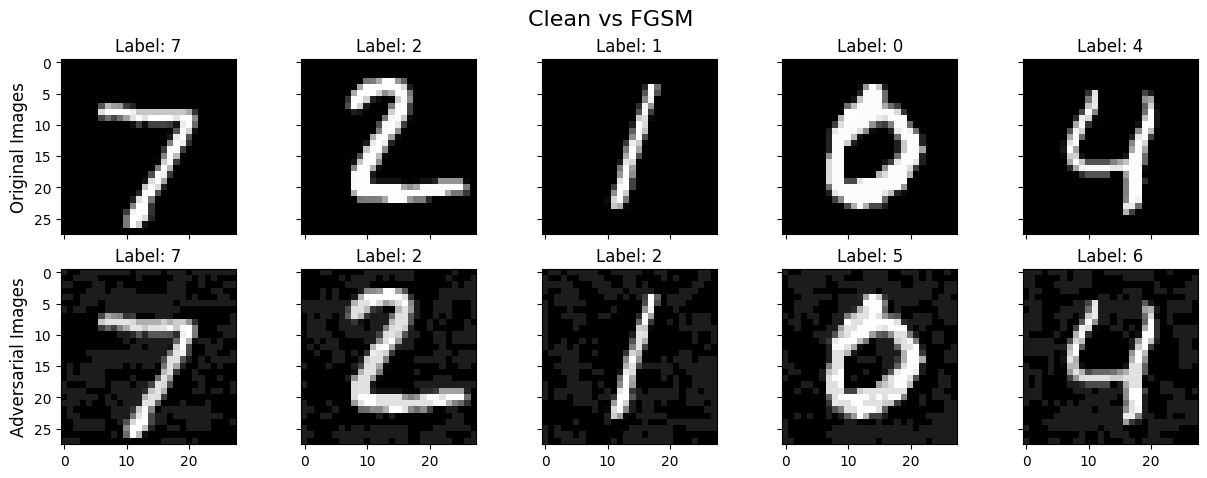

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on BIM adversarial test data:  0.1344


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

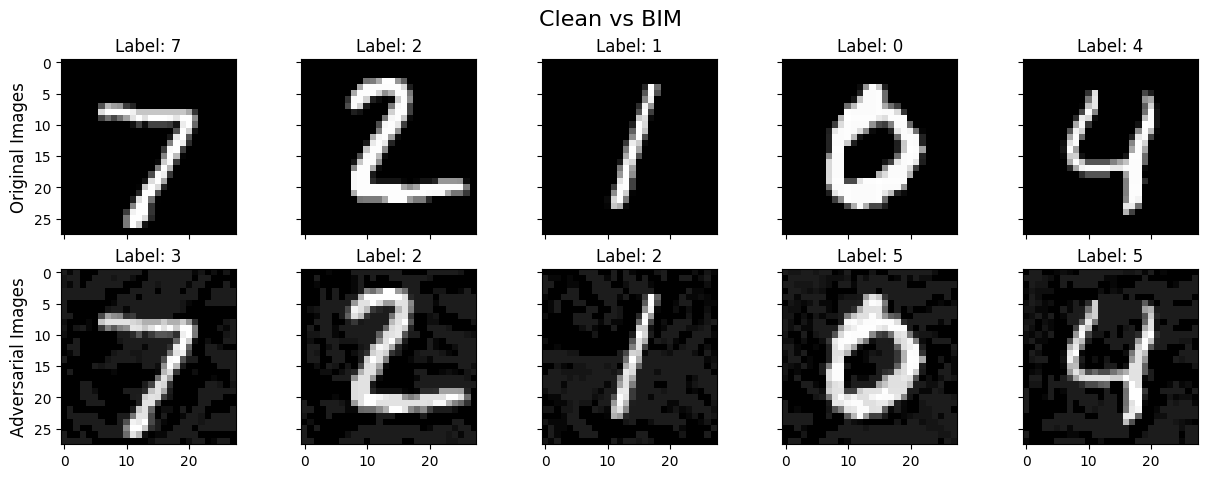

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on PGD adversarial test data:  0.1344


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

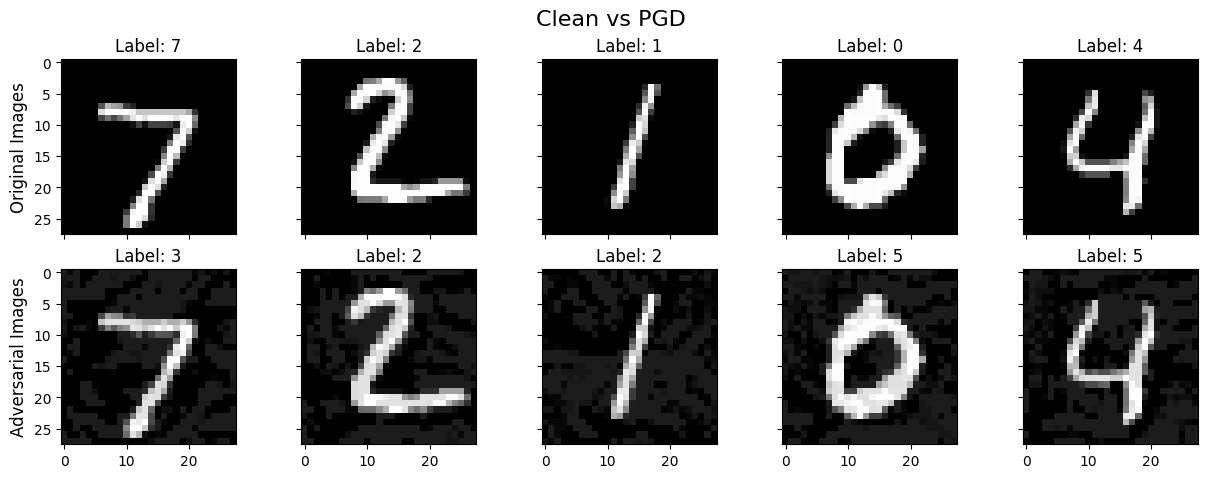

DeepFool:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on DeepFool adversarial test data:  0.0881


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

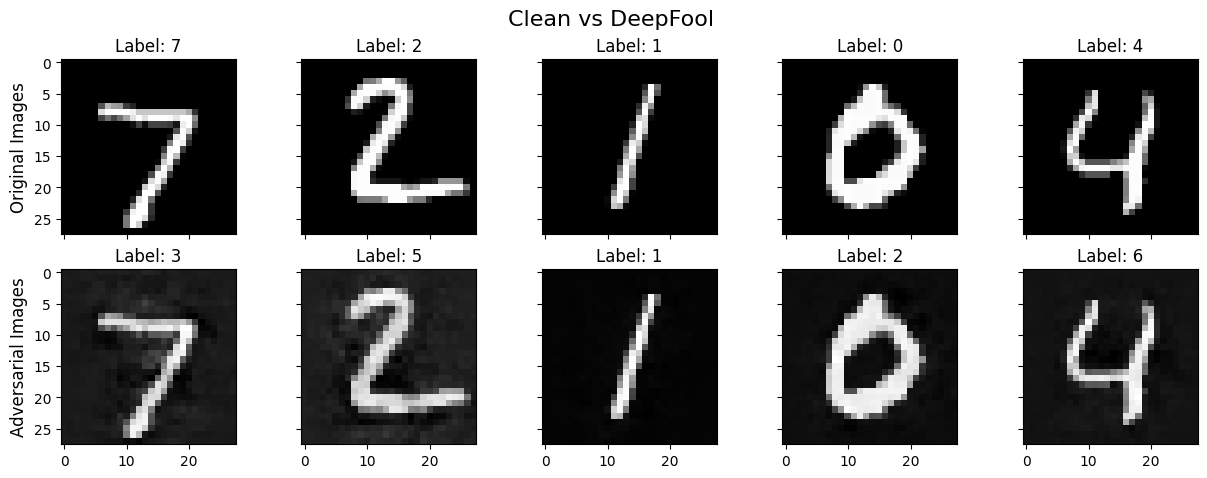

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

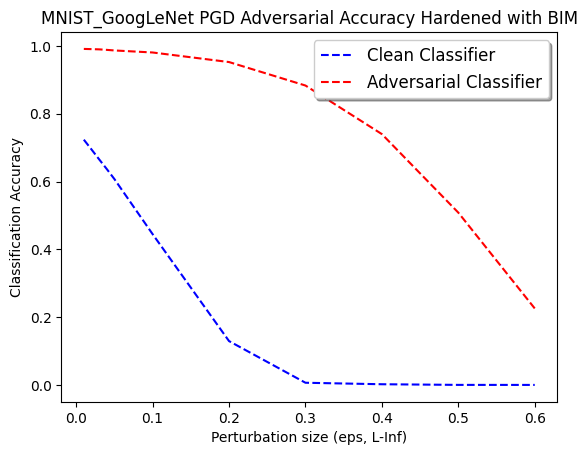

Hardened model accuracy on clean test data:  0.9918


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Hardened model accuracy on BasicIterativeMethod adversarial test data:  0.9531


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

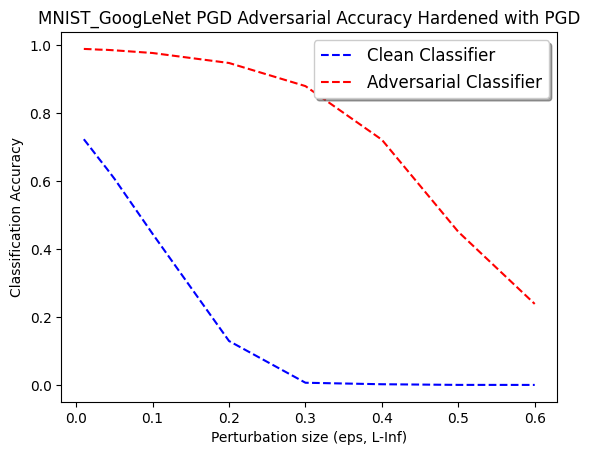

Hardened model accuracy on clean test data:  0.9905


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Hardened model accuracy on ProjectedGradientDescent adversarial test data:  0.9493


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

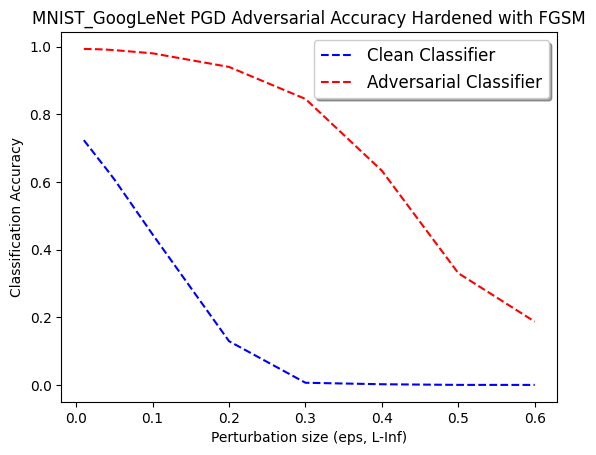

Hardened model accuracy on clean test data:  0.9936
Hardened model accuracy on FastGradientMethod adversarial test data:  0.9629


In [10]:
# load the GoogLeNet model
clean_model = MNIST_GoogLeNet()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_GoogLeNet.pth'))
clean_model.eval()

run_adversarial_process(clean_model, BATCH_SIZE, EPS, 'MNIST_GoogLeNet', 'MNIST_GoogLeNet PGD Adversarial Accuracy')

Clean accuracy: 0.9934
Accuracy on FGSM adversarial test data:  0.1247


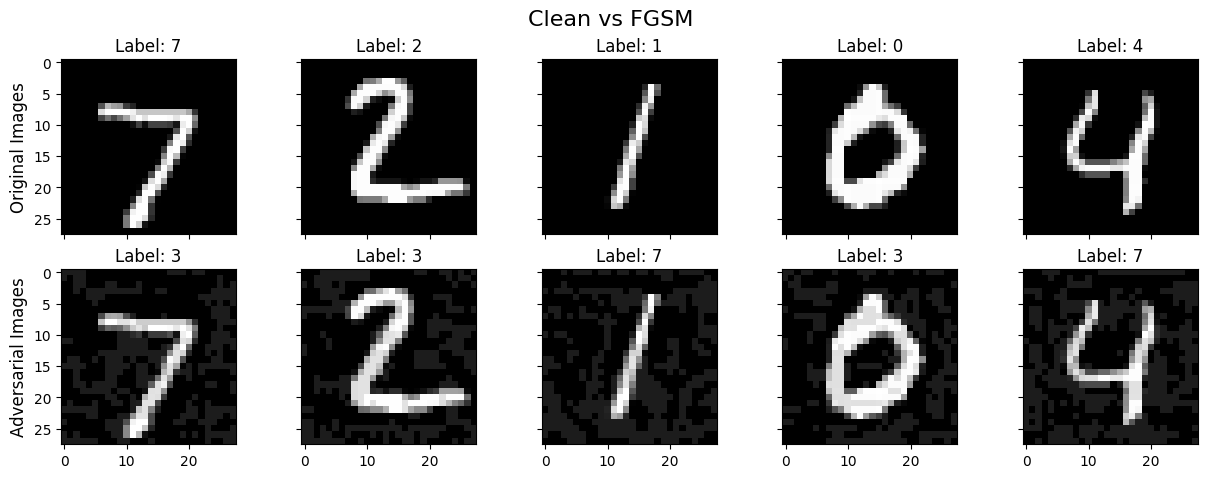

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on BIM adversarial test data:  0.088


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

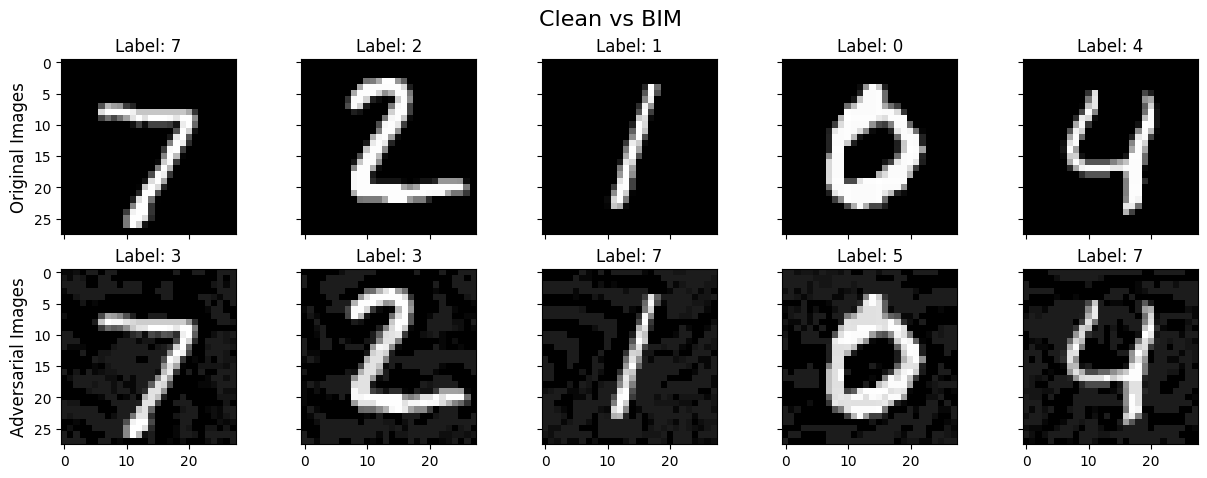

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on PGD adversarial test data:  0.088


PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/1 [00:00<?, ?it/s]

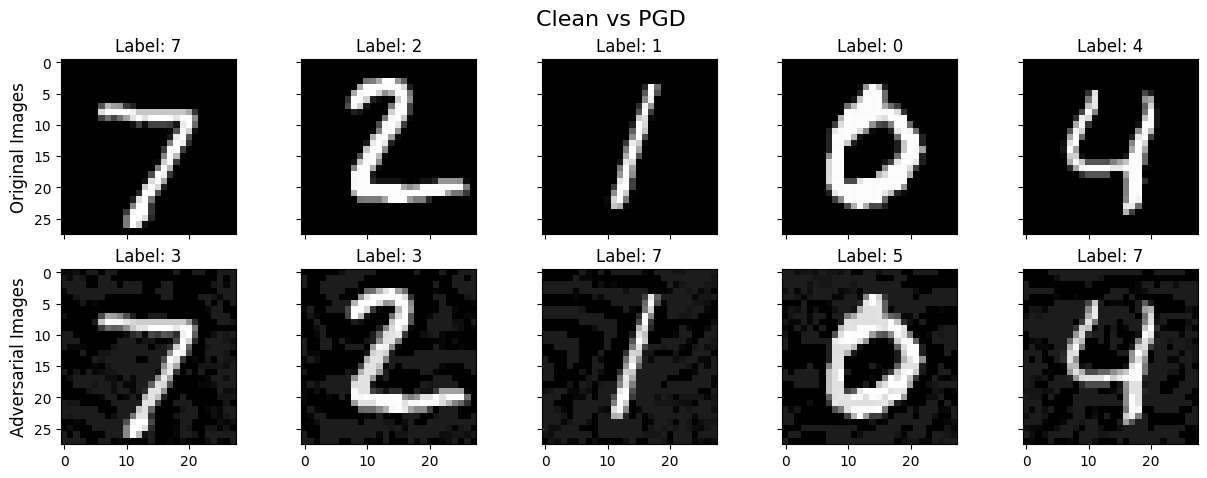

DeepFool:   0%|          | 0/10 [00:00<?, ?it/s]

Accuracy on DeepFool adversarial test data:  0.3175


DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

DeepFool:   0%|          | 0/1 [00:00<?, ?it/s]

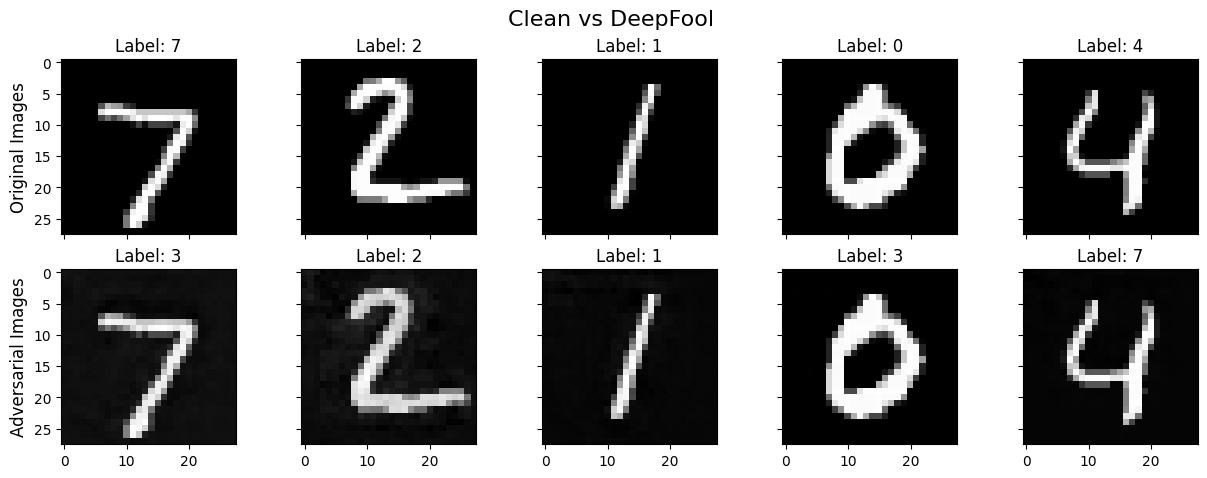

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

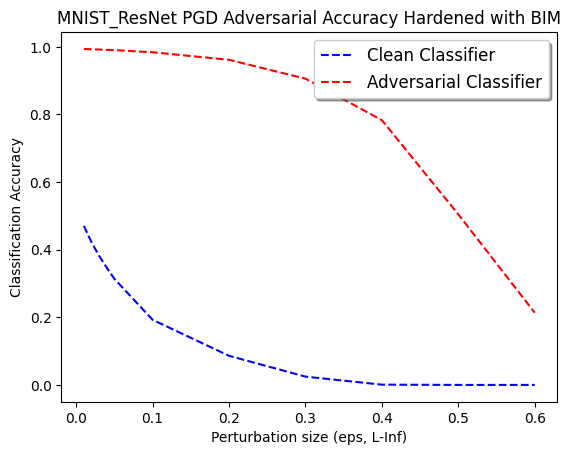

Hardened model accuracy on clean test data:  0.9944


PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

Hardened model accuracy on BasicIterativeMethod adversarial test data:  0.9618


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

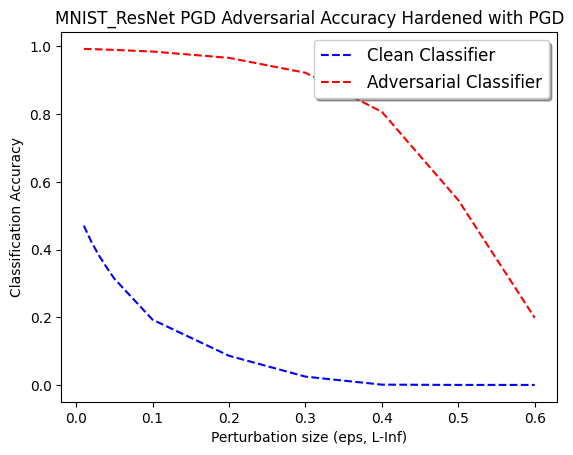

Hardened model accuracy on clean test data:  0.9933
Hardened model accuracy on ProjectedGradientDescent adversarial test data:  0.9663


Precompute adv samples:   0%|          | 0/1 [00:00<?, ?it/s]

Adversarial training epochs:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

PGD - Batches:   0%|          | 0/10 [00:00<?, ?it/s]

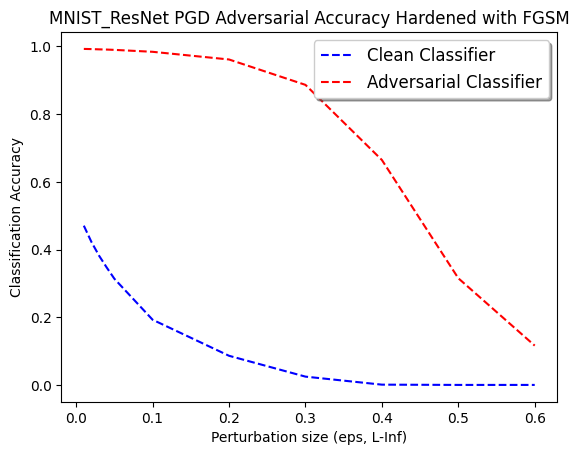

Hardened model accuracy on clean test data:  0.993
Hardened model accuracy on FastGradientMethod adversarial test data:  0.9713


In [11]:
# load the ResNet model
clean_model = MNIST_ResNet()
clean_model.load_state_dict(torch.load('models/clean_state/MNIST_ResNet.pth'))
clean_model.eval()


run_adversarial_process(clean_model, BATCH_SIZE, EPS, 'MNIST_ResNet', 'MNIST_ResNet PGD Adversarial Accuracy')